# Can junk radiation be IDENTIFIED using the hilber transform??

In [2]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
%matplotlib inline
# rc('text', usetex=True)
from matplotlib.pyplot import *
# Import needed packages from positive
from positive.plotting import sYlm_mollweide_plot
from positive import alert
# Import other usefuls
from os.path import expanduser
from nrutils import scsearch,gwylm
from nrutils.core.basics import *
from numpy import *

(positive)>> Applying custom matplotlib settings.


In [3]:
A = scsearch(institute='bam',keyword='q1a04t150_dP0_T_96_552',verbose=True)

(scsearch)>> Found institute (=bam) keyword.
(scsearch)>> Found keyword (=q1a04t150_dP0_T_96_552) keyword.
(scsearch)>> Found verbose (=True) keyword.
(scsearch)>> List of keywords or string keyword found: ALL scentry objects matching will be passed. To pass ANY entries matching the keywords, input the keywords using an iterable of not of type list.
## Found 1 possibly degenerate simulations:
[0001][hogshead] q1: 2chi0.40-p-q1.00	(q1a04t150_dP0_T_96_552)



In [4]:
y = gwylm( A[0], lmax=2, verbose=True, clean=False, dt=0.5,pad=500 )

(gwylm)>> Found dt (=0.5) keyword.
(gwylm)>> Found lmax (=2) keyword.
(gwylm)>> Found pad (=500) keyword.
(gwylm)>> Found scentry_obj (=<nrutils.core.nrsc.scentry instance at 0x11922c830>) keyword.
(gwylm)>> Found verbose (=True) keyword.
(__init__)>> Using default M_RELATIVE_SIGN_CONVENTION of 1
(gwylm)>> The (extraction_parameter,level) is (5,7), which differs from the config values of (5,5). You have either manually input the non-config values, or the handler has set them by looking at the contents of the simulation directory. 
(__make_lmlist__)>> The following spherical multipoles will be loaded:[(2, 2), (2, -2), (2, -1), (2, 0), (2, 1)]
(load)>> Using the default extraction_parameter of 5
(load)>> Using the default level of 7
(load)>> Loading: psi3col.r5.l7.l2.m2.gz
(straighten_wfarr!)>> The time series has been found to be non-monotonic. We will sort the data to enforce monotinicity.
(straighten_wfarr!)>> The waveform time series is now monotonic.
(straighten_wfarr!)>> Repeated t

2326 2325


(-0.0069804289434729589, 0.0063948097432808201)

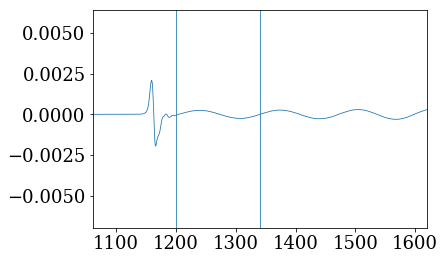

In [91]:



def find_junk_index(td_wfarr):
    '''
    Find the approximate location of the junk radiation given a
    time domain waveform array by making use of the irregular
    frequency domain behavior of the junk radiation: the
    physical waveform dominates either positive or negative
    freqs while the junk radiation is broadly spread. As as
    result, the hilbert transform of plus and cross (i.e. IFFT
    of either after zero-ing pos or negative freqs) differ
    predominantly by the junk radiation.
    '''

    #
    from numpy import argmax
    from scipy.signal import hilbert

    #
    hp = td_wfarr[:,1]
    hc = td_wfarr[:,2]
    hp_ = hilbert(hp)
    hc_ = hilbert(hc)

    #
    dp = hp + hc_.imag
    dc = hc - hp_.imag

    # Find the locations of plus and cross junk
    dexmax_c = argmax( abs(dc) )
    dexmax_p = argmax( abs(dp) )
    dexmax = max( (dexmax_p,dexmax_c) )

    #
    ans = dexmax
    return ans

#
def find_wfarr_turnon_indeces(wfarr,plt=False,n=1):
    
    t,hp,hc = wfarr[k:,:].T
    amp = abs(hp+1j*hc)
    max_amp = max(amp)

    #
    amp_mask = amp>0.001*max_amp
    amp_start_dex = find( amp_mask )[0]
    locs = findroots( hp[ amp_mask ] )

    dt = t[1]-t[0]
    taumaxdex = n*2*max( diff(locs) )
    taumax = taumaxdex*dt

    if plt: figure()
    spacer = 250

    if plt: plot( t, hp, 'k' )
    if plt: plot( t[amp_mask], hp[amp_mask], lw=6, alpha=0.25 )
    if plt: plot( t[locs+amp_start_dex], hp[locs+amp_start_dex], 'og' )

    tjdex_ = find_junk_index(wfarr[k:,:])
    tj_ = t[ tjdex_ ]
    locs_ = locs[ abs(locs-(tjdex_-amp_start_dex))>taumaxdex/4 ]

    tjdex = amp_start_dex + locs_[ argmin( abs(locs_-(tjdex_-amp_start_dex)) ) ]
    tj = t[ tjdex ]

    print tjdex_, locs[0]+amp_start_dex

    if plt: xlim( tj_-spacer,tj_+2*spacer )
    if plt: ylim(-0.003,0.003)
    if plt: axvline( tj_, color='r' )
    if plt: axvline( tj, color='b' )


    if plt: axvline( tj+taumax, color='b', ls='--' )
        
    return tjdex,tjdex+taumaxdex


#
k = 0 # 5500
l,m = 2,2
jcdex,jedex = find_wfarr_turnon_indeces( y[l,m]['psi4'].wfarr )

t,yp,yx = y[l,m]['psi4'].wfarr.T
plot( t, yp )
axvline( t[jcdex] )
axvline( t[jedex] )
xlim( t[jcdex]+(t[jcdex]-t[jedex]) , t[jcdex]-3*(t[jcdex]-t[jedex]) )
ylim( lim(yp)/10 )


In [20]:
?findpeaks

(2600, 2800)

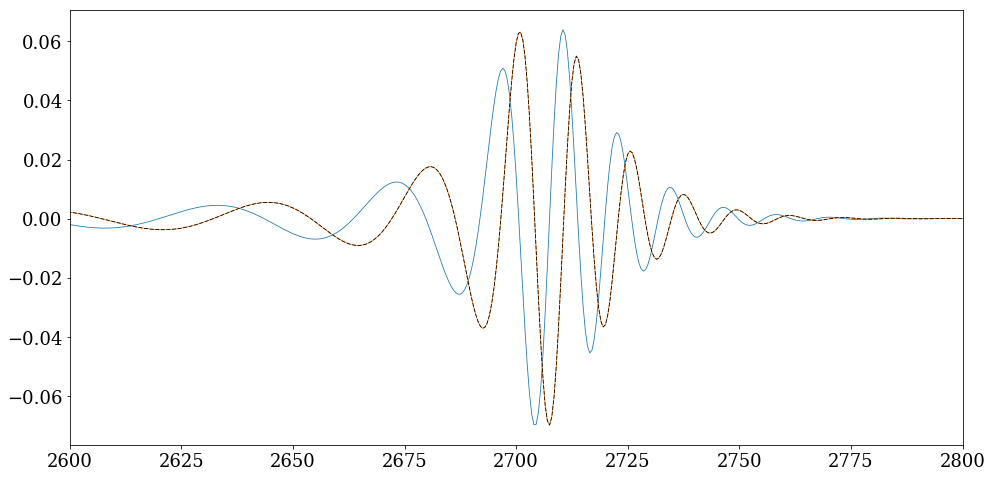

In [8]:
fig = figure( figsize=2*figaspect(0.5) )
plot( y.t, hp )
plot( y.t, hc )
plot( y.t, hp_.imag, '--k' )
xlim([2600,2800])
# xlim([1500,2760])

(-0.0038060269947439796, 0.004831471663210787)

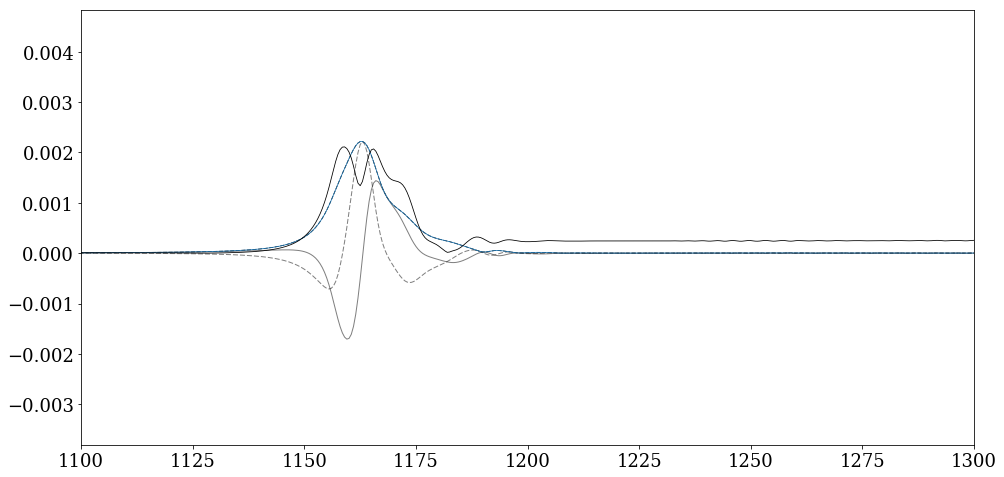

In [9]:
fig = figure( figsize=2*figaspect(0.5) )
u = (hp_.imag - hc)/2
v = (-hc_.imag - hp)/2
z = u + 1j*v

U = hilbert(u)
V = hilbert(v)

# plot( y.t, hp,'r' )
# plot( y.t, hc,'r',ls='--' )

plot( y.t, U.imag, color='k',alpha=0.5,lw=1 )
plot( y.t,-V.imag, color='k',alpha=0.5,lw=1,ls='--' )

#
plot( y.t, abs( U.imag + 1j*V.imag ), '--k' )

plot( y.t, abs(z) )
plot( y.t, y[2,2]['psi4'].amp,'k' )
xlim([ 1100,1300 ])
ylim((-0.0038060269947439796, 0.004831471663210787))

(-0.01, 0.01)

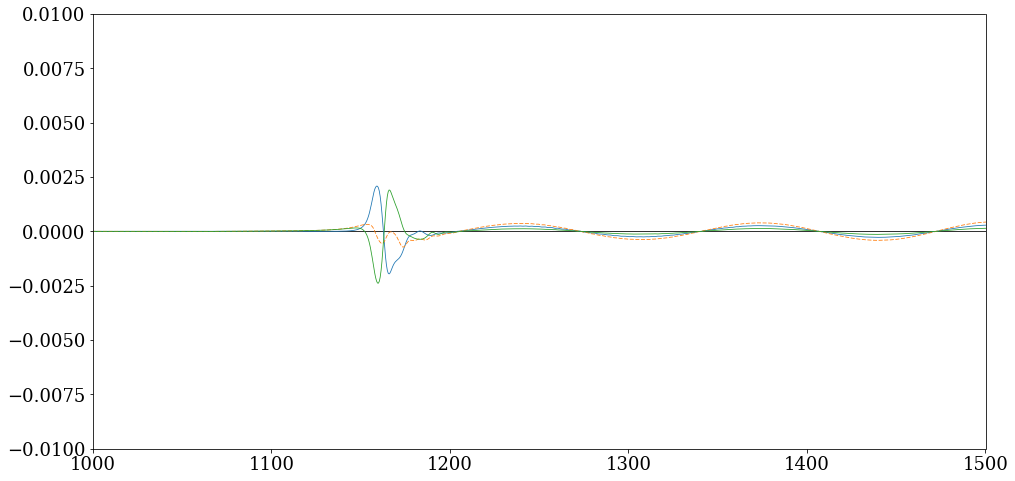

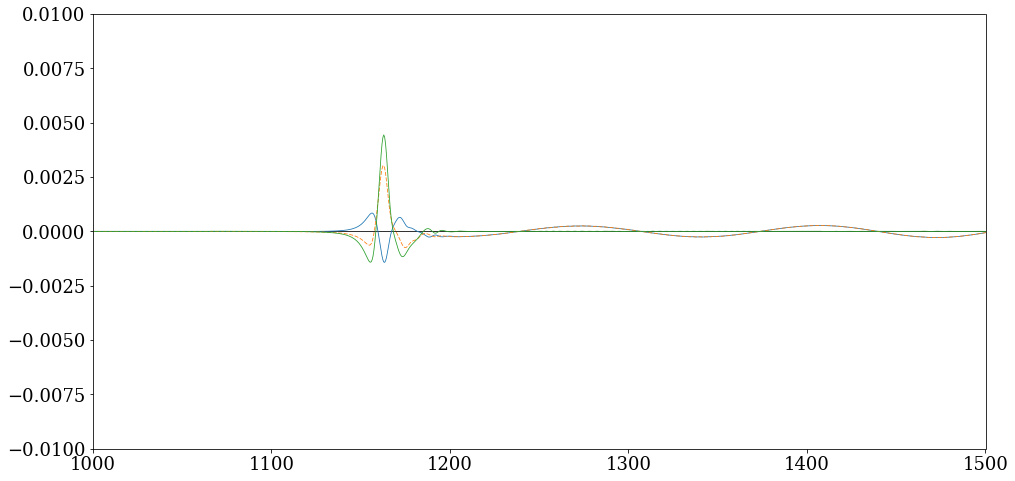

In [299]:
fig = figure( figsize=2*figaspect(0.5) )
res = hp_.imag/2 - hc
cres = hilbert(res)

axhline(0,color='k')
plot( y.t, hp )
plot( y.t, hp+cres.imag, '--' )
plot( y.t, cres.imag )
xlim([ 1000,1500 ])
ylim([-0.01,0.01])

####

fig = figure( figsize=2*figaspect(0.5) )
res = -hc_.imag - hp
cres = hilbert(res)

axhline(0,color='k')
plot( y.t, hc )
plot( y.t, hc-cres.imag, '--' )
# plot( y.t, cres.real )
plot( y.t,-cres.imag )
xlim([ 1000,1500 ])
ylim([-0.01,0.01])

In [300]:

#
def hilbertclean( complex_y ):
    
    # Import usefuls
    from scipy.signal import hilbert
    
    # Copy input data 
    input_complex_y = complex_y
    complex_y = input_complex_y.copy()
    
    #
    fac = 1
    for k in range(3):
    
        # Extract real and imag 
        yr,yc = complex_y.real, complex_y.imag

        # Compute hilbert transform of each 
        YR,YC = hilbert(yr),hilbert(yc)
        
        u = (YR.imag - yc)/2
        v = (YC.imag + yr)/2

        U = hilbert(u)
        V = hilbert(v)

        # If the the data are analytic, then yc = YR.imag = YC.real
        # and yr = YR.real = YC.imag. Define holders of related differences.
        #u = YR.imag - YC.real
        #v = YR.real + YC.imag
        #u = YR.imag - yc
        #v = yr + YC.imag

        # Furthermore, u and v should be related via their hilbert transforms
        #U = hilbert(u)
        #V = hilbert(v)

        #
        dy = U.imag + 1j * V.imag
        #
        print sum(abs(dy))
        complex_y += fac*dy
        
        #
        figure( figsize=2*figaspect(0.5) )
        
#         plot( abs(input_complex_y),color='k' )
#         plot(-abs(input_complex_y),color='k' )
#         plot( complex_y.real )
#         plot( complex_y.imag )
#         plot( abs(complex_y),'--k' )
#         plot(-abs(complex_y),'--k' )
        
        #plot( u )
        #plot( v )
        
#         plot( u )
#         plot( v )
        
#         plot( input_complex_y.real,color='k',label='input' )
#         plot( complex_y.real,label='adjusted' )
#         plot( dy.real, '--r' )
        
        plot( input_complex_y.imag,color='k',label='input' )
        plot( complex_y.imag,label='adjusted' )
        plot( dy.imag, '--r' )
        
#         plot( input_complex_y.imag,color='k',label='input' )
#         plot( input_complex_y.imag+u,label='adjusted' )
#         plot( u, '--r' )
        
        legend()
        xlim([ 2000,2700 ])
        ylim([-0.01,0.01])
    
    #
    return complex_y
    
    
    


0.0798398385865
1.28056325509e-12
1.25066679289e-12


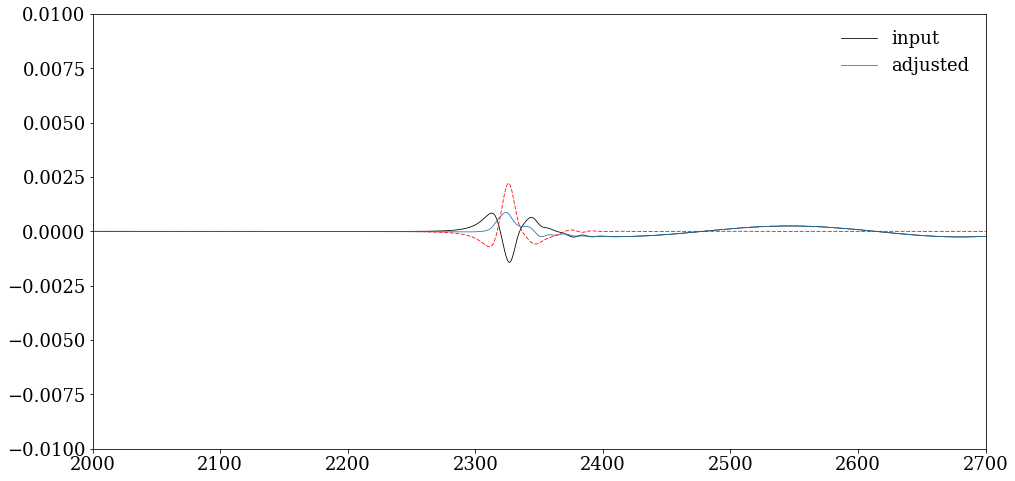

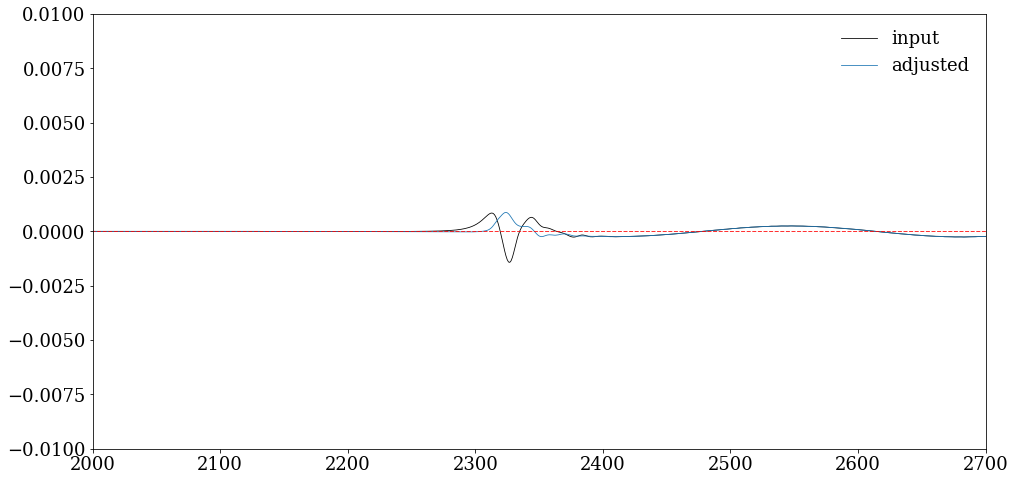

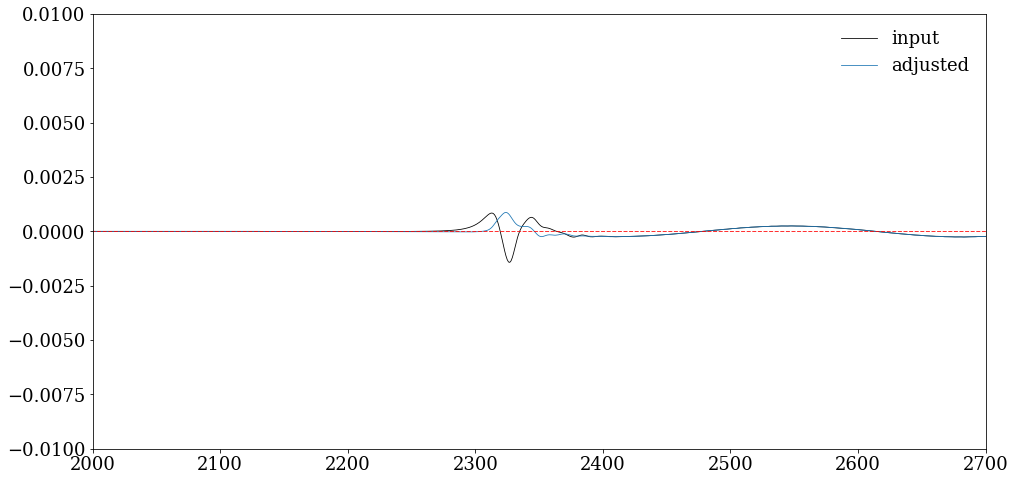

In [301]:

#
a = y[2,2]['psi4'].y
b = hilbertclean( a )



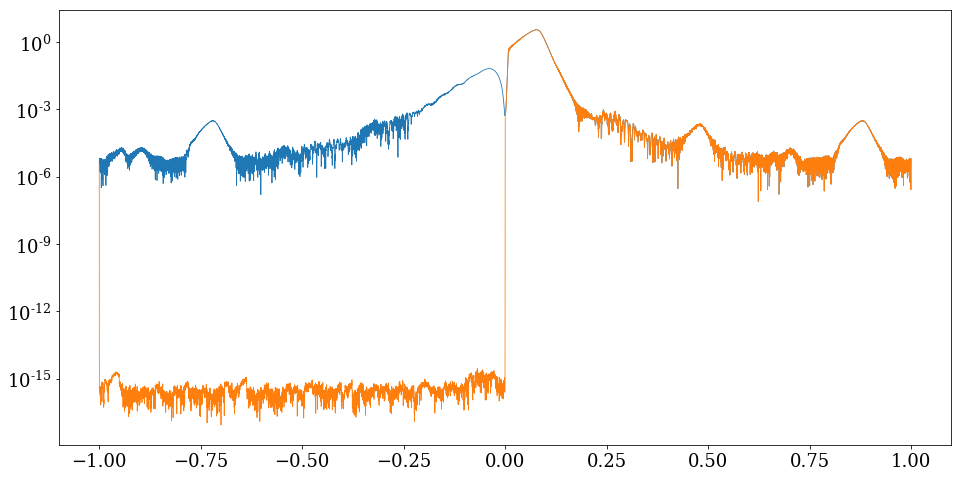

In [303]:
figure( figsize=2*figaspect(0.5) )
# plot(y.t,abs(b-a))
# plot(y.t,res)
plot( y[2,2]['psi4'].f, abs(fft.fftshift(fft.fft(a))) )
plot( y[2,2]['psi4'].f, abs(fft.fftshift(fft.fft(b))) )
yscale('log')
# xscale('log')
# plot( y.t, abs(b) )
# xlim(array([ 2000,2700 ])*y.dt)
# ylim([-0.01,0.01])

* $\psi_4 = \psi = \psi_a + \psi_n$
* $\psi_a$ is an analytic function, while $\psi_n$ is not
* $\hat{H}$ is the Hilbert transform, where $\hat{H}f = f + i\bar{f}$ is analytic
---
* $\hat{H}\psi = \psi + i\bar{\psi}$
* $\hat{H}\psi =  \psi_r + i\psi_c + i ( \bar{\psi}_r + i\bar{\psi}_c )$
* $\hat{H}\psi =  \psi_r - \bar{\psi}_c + i( \psi_c + \bar{\psi}_r  )$
* $\hat{H}\psi_a =  \psi_{ra} - \bar{\psi}_{rc} + i( \psi_{rc} + \bar{\psi}_{ar}  )$
---
* $\hat{H}\psi \approx 2\psi$

In [272]:
?hilbert

In [275]:
a = hilbert(y[2,2]['psi4'].y.real) + 1j* hilbert(y[2,2]['psi4'].y.imag)

(-0.01, 0.01)

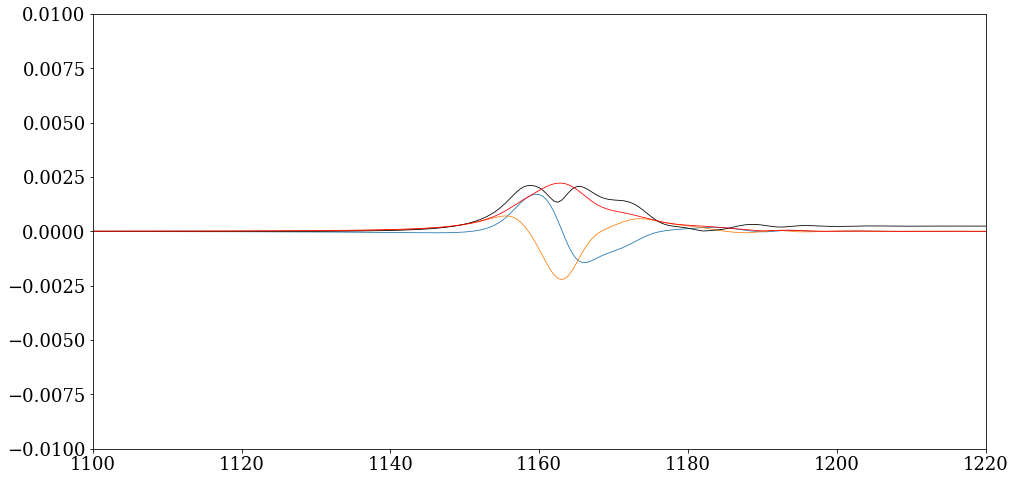

In [287]:
figure( figsize=2*figaspect(0.5) )
# plot( y.t, a.real/2 )
plot( y.t, y[2,2]['psi4'].y.real - a.real/2)
plot( y.t, y[2,2]['psi4'].y.imag - a.imag/2)
plot(y.t,y[2,2]['psi4'].amp,'k')
plot(y.t,abs(y[2,2]['psi4'].y - a/2),'r')

xlim([ 1100,1220 ])
ylim([-0.01,0.01])